## <font color = "lightseagreen">0. Importing Libraries<font>

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import sys

###import datetime

# path and data management
import os
import shutil

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import time
import re
import warnings

# image manipulation/processing
import rioxarray
from PIL import Image
from IPython.display import Image as ipimage
import odc

# FROM ISI'S REPO
import shutil # High-level file operations
import random # to generate random samples

# Computer Vision
import tensorflow as tf # machine learning and neural networks
from tensorflow import keras # deep learning and neural networks
from tensorflow.keras import layers # layers for neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # real-time data augmentation
# NOT FROM ISI'S REPO

# classification
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# setting session parameters
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## <font color = "lightseagreen">1. Importing Datasets<font>

<h3 style = "color:dimgray">Data description:</h3>
<font color = = "dimgray">The full dataset, consisting of 4 folders representing the 4 categories "cloudy", "desert", "green area" and "water", with 1500, 1131, 1500 and 1500 images respectively was retrieved from <a href="https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification">Satellite Image Classification</a>.<font>

<h3 style = "color:dimgray">Goal:</h3>
<font color = = "dimgray">The use of maching learning algorithm(s) for the classification of the images in the abovementioned categories.<font>

In [3]:
# Defining data paths. Note that all the files were initially in the same folders per category and since most of them will 
# be used for training the model, they were saved the "train" folder. Later on they will be sampled to create the validation and test sets
data_path = os.path.join(os.getcwd(), "data")

cloudy_train = os.path.join(data_path, "train/cloudy")
desert_train = os.path.join(data_path, "train/desert")
forest_train = os.path.join(data_path, "train/green_area")
water_train = os.path.join(data_path, "train/water")

# defining validation directories to be created
cloudy_valid = os.path.join(data_path, "valid/cloudy")
desert_valid = os.path.join(data_path, "valid/desert")
forest_valid = os.path.join(data_path, "valid/green_area")
water_valid = os.path.join(data_path, "valid/water")

# defining test directory to be created
imbalanced_test_dir = os.path.join(data_path, "test/test")  # prefix imbalanced will make sense later along the script

# listing image names
cloudy_img_lst = os.listdir("data/train/cloudy")
desert_img_lst = os.listdir("data/train/desert")
forest_img_lst = os.listdir("data/train/green_area")
water_img_lst = os.listdir("data/train/water")

In [4]:
# adapted from code found on Github @isi_mube and @sabinagio
def fix_valid_test_dirs(validation_dir_list, test_dir):
    # fixing validation directories
    for val_dir in validation_dir_list:
        os.makedirs(val_dir, exist_ok=True)
    # fixing test directory
    os.makedirs(test_dir, exist_ok=True)

fix_valid_test_dirs([cloudy_valid, desert_valid, forest_valid, water_valid], imbalanced_test_dir)

## <font color = "lightseagreen">2. Data Cleaning<font>

In [5]:
# On examination of the folders' contents, it was made clear that the cloudy images all have the prefix "train" since the
# models will be trained and validated using samples of all images and for the avoidance of confusion, renaming them seems only right
print("Cloudy image title check:", sample(cloudy_img_lst, 5), "\n")
print("Desert image title check:", sample(desert_img_lst, 5), "\n")
print("Green area title prefix check:", sample(forest_img_lst, 5), "\n")
print("Water image title check:", sample(water_img_lst, 5))

Cloudy image title check: ['train_20957.jpg', 'train_5925.jpg', 'train_31951.jpg', 'train_4587.jpg', 'train_14787.jpg'] 

Desert image title check: ['desert(679).jpg', 'desert(195).jpg', 'desert(155).jpg', 'desert(738).jpg', 'desert(671).jpg'] 

Green area title prefix check: ['Forest_747.jpg', 'Forest_2843.jpg', 'Forest_760.jpg', 'Forest_1672.jpg', 'Forest_2531.jpg'] 

Water image title check: ['SeaLake_1135.jpg', 'SeaLake_2685.jpg', 'SeaLake_741.jpg', 'SeaLake_1608.jpg', 'SeaLake_1151.jpg']


In [6]:
# double-checking
pattern1 = r"train_(\d+)"  # pattern provided by ChatGPT
pattern2 = r"cloudy_(\d+)"
num_match1 = 0
num_match2 = 0

# iterating
for filename in cloudy_img_lst:
    match1 = re.match(pattern1, random.choice(cloudy_img_lst))
    match2 = re.match(pattern2, random.choice(cloudy_img_lst))
    if match1:
        num_match1 += 1
    elif match2:
        num_match2 += 1
    else:
        print("no match", filename)

print("num train", num_match1)
print("num cloudy", num_match2)

num train 1500
num cloudy 0


In [7]:
# finally changing names of files in direcrory
for filename in cloudy_img_lst:
    match = re.match(pattern1, filename)
    if match:
        num = match.group(1)  # keeping number part intact
        new_filename = f"cloudy_{num}.jpg"  # defining new filename
        os.rename(os.path.join(cloudy_train + "/" + filename), (cloudy_train + "/" + new_filename))
    else:
        continue

# redefining cloudy image list with new file names
cloudy_img_lst = os.listdir("data/train/cloudy")

# double-checking
print("Cloudy image title check:", sample(cloudy_img_lst, 5), "\n")

Cloudy image title check: ['cloudy_13613.jpg', 'cloudy_30862.jpg', 'cloudy_39830.jpg', 'cloudy_15489.jpg', 'cloudy_13497.jpg'] 



In [8]:
# also changing the name of "SeaLake" images to "water" to avoid confusion
pattern1 = r"SeaLake_(\d+)"  # pattern provided by ChatGPT

for filename in water_img_lst:
    match = re.match(pattern1, filename)
    if match:
        num = match.group(1)  # keeping number part intact
        new_filename = f"water_{num}.jpg"  # defining new filename
        os.rename(os.path.join(water_train + "/" + filename), (water_train + "/" + new_filename))
    else:
        continue

# redefining cloudy image list with new file names
water_img_lst = os.listdir("data/train/water")

# double-checking
print("Water image title check:", sample(water_img_lst, 5), "\n")

Water image title check: ['water_1416.jpg', 'water_2320.jpg', 'water_1786.jpg', 'water_2028.jpg', 'water_984.jpg'] 



In [9]:
print("count_cloudy:", len(cloudy_img_lst))
print("count_desert:", len(desert_img_lst))
print("count_water:", len(water_img_lst))
print("count_cloudy:", len(water_img_lst), "\n")
print("count_all:", len(cloudy_img_lst + desert_img_lst + forest_img_lst + water_img_lst))

count_cloudy: 1500
count_desert: 1131
count_water: 1500
count_cloudy: 1500 

count_all: 5631


In [10]:
# creating dataframe with image names and categories
image_df = pd.DataFrame(columns = ["img_name", "img_class"])

# list with all image names
img_list = cloudy_img_lst + desert_img_lst + forest_img_lst + water_img_lst

# filling out image name column
image_df["img_name"] = img_list

In [11]:
# regex patterns to fill "class" column
pattern_cl = r"^cloudy"
pattern_des = r"^desert"
pattern_gr = r"^Forest"
pattern_wa = r"^water"

# filling out class column
for file_name in image_df.img_name:
    # match objects or None
    match1 = re.search(pattern_cl, str(file_name))
    match2 = re.search(pattern_des, str(file_name))
    match3 = re.search(pattern_gr, str(file_name))
    match4 = re.search(pattern_wa, str(file_name))
    if match1:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match1.group(0))
    elif match2:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match2.group(0))
    elif match3:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match3.group(0))
    elif match4:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match4.group(0))
    else:
        continue

image_df

,img_name,img_class
0,cloudy_10021.jpg,cloudy
1,cloudy_10043.jpg,cloudy
2,cloudy_10070.jpg,cloudy
3,cloudy_10081.jpg,cloudy
4,cloudy_10096.jpg,cloudy
...,...,...
5626,water_995.jpg,water
5627,water_996.jpg,water
5628,water_997.jpg,water
5629,water_998.jpg,water


In [12]:
# checking to see if all rows were filled
image_df.isna().sum()

img_name     0
img_class    0
dtype: int64

In [13]:
# # taking a closer look into the filenames
# for name in image_df.img_name:
#     sys.stdout.write(name + "\n")

<font color = "dimgray">Some of the images in the desert folder seem to be duplicated as pairs like "desert(1007).jpg" and "desert(1007) (1).jpg" exist. What is more, the filenames of only this folder are written in a different folder<font>

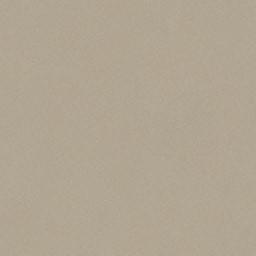

In [14]:
# checking visually
ipimage(desert_train + "/" + "desert(1007).jpg", width=200)

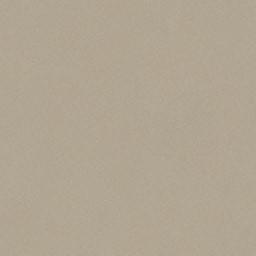

In [15]:
ipimage(desert_train + "/" + "desert(1007) (1).jpg", width=200)

In [16]:
# double-checking with code
try:
    ipimage(desert_train + "/" + "desert(1007).jpg", width=200) == ipimage(desert_train + "/" + "desert(1007) (1).jpg", width=200)
except:
    print("Not the same")
else:
    print("The same")

The same


In [17]:
# Disposing of spaces in names and standardizing name format
pattern_s = r"\s\(\d+\)" # regex writtern with the help of ChatGPT

# Dirs to iterate upon
list_paths_train = [cloudy_train, desert_train, forest_train, water_train]

# Iterating on each path
for the_dir in list_paths_train:
    # Iterating for each filename in the dataframe 
    for filename in image_df.img_name:
        # File directory
        the_file = the_dir + "/" + filename
        # Checking first if file directory exists
        if os.path.exists(the_file):
            # If exists check if pattern matches
            match = re.search(pattern_s, filename)
            if match:
                # Removing image from dir
                os.remove(the_file)
                # Removing its record from image_df
                image_df = image_df.drop(image_df.loc[image_df["img_name"] == filename].index)
            elif not match:
                # If image is no duplicate, just standardize its name
                new_filename = filename.replace("(", "_", 1).replace("(", "").replace(")", "").lower()
                os.rename(os.path.join(the_dir + "/" + filename), (the_dir + "/" + new_filename))
        # If path doesn't exist, i.e. file is in different path
        else:
            continue

In [18]:
# applying name standardization to the df
for column in image_df.columns:
    image_df[column] = image_df[column].apply(lambda x : str(x).replace("(", "_", 1).replace("(", "").replace(")", "").lower())

image_df = image_df.sample(frac = 1).reset_index(drop = True)
image_df

,img_name,img_class
0,cloudy_17556.jpg,cloudy
1,cloudy_25127.jpg,cloudy
2,cloudy_15562.jpg,cloudy
3,water_1147.jpg,water
4,water_1788.jpg,water
...,...,...
5587,water_2544.jpg,water
5588,forest_2208.jpg,forest
5589,desert_490.jpg,desert
5590,forest_2058.jpg,forest


In [19]:
# Before moving on to potential changes in the folders, let's make sure we know the min and max image sizes, in case resizing needs to be performed
# Tuple pairs of paths for directories and lists of names per directory. Tuples are highly convenient, as they allow for targeting only specific folders
# during iterations, instead of going over all potential directories with conditionals to find out whether they exist or not
# Since the names of the files have changed, the lists of files must be adapted accordingly
cloudy_img_lst = os.listdir("data/train/cloudy")
desert_img_lst = os.listdir("data/train/desert")
forest_img_lst = os.listdir("data/train/green_area")
water_img_lst = os.listdir("data/train/water")

cloudy_siz_tup = cloudy_train, cloudy_img_lst
desert_siz_tup = desert_train, desert_img_lst
forest_siz_tup = forest_train, forest_img_lst
water_siz_tup = water_train, water_img_lst


# List to store dimensions of images
size_list = []

# Iterating on tuple list
for pair in [cloudy_siz_tup, desert_siz_tup, forest_siz_tup, water_siz_tup]:
    # Iterating on image list
    for filename in pair[1]:
        # Getting item from path using second item in tuple
        img_get = Image.open(pair[0] + "/" + filename)
        # Storing image size
        img_size = img_get.size
        size_list.append(img_size)

# Storing max and min sizes 
res_max = list(map(max, zip(*size_list)))
res_min = list(map(min, zip(*size_list)))

print("Maximum image size:", res_max)
print("Minimum image size:", res_min)

Maximum image size: [256, 256]
Minimum image size: [64, 64]


In [5]:
#image_df.to_csv("data/image_df.csv", index=0)
image_df = pd.read_csv("data/image_df.csv")

## <font color = "lightseagreen">3. Addressing Data Imbalance<font>

In [22]:
# let's take a look at the value counts
image_df["img_class"].value_counts()

cloudy    1500
water     1500
forest    1500
desert    1092
Name: img_class, dtype: int64

<font color = "dimgray">The desert class was already under-represented, but after the removal of duplicate images, it  became even more so.<font>

<font color = "dimgray">2 folders will be used. One for the baseline models using the imbalanced data and one for the models using the balanced data.<font>

In [6]:
# Creating path
data_balance = os.path.join(os.getcwd(), "data_balance")

# Copying data
# dest = shutil.copytree(data_path, data_balance)

# Checking that tree has been copied
# print(os.listdir(data_balance))

# image_df.csv was also copied but can easily just be deleted manually which will also be the case

In [7]:
# defining new paths for the image folders
cloudy_btrain = os.path.join(data_balance, "train/cloudy")
desert_btrain = os.path.join(data_balance, "train/desert")
forest_btrain = os.path.join(data_balance, "train/green_area")
water_btrain = os.path.join(data_balance, "train/water")

# defining new validation directories to be created
cloudy_bvalid = os.path.join(data_balance, "valid/cloudy")
desert_bvalid = os.path.join(data_balance, "valid/desert")
forest_bvalid = os.path.join(data_balance, "valid/green_area")
water_bvalid = os.path.join(data_balance, "valid/water")

# defining new test directory to be created
balanced_test_dir = os.path.join(data_balance, "test/test")

# fixing them up so they don't get overwritten
fix_valid_test_dirs([cloudy_bvalid, desert_bvalid, forest_bvalid, water_bvalid], balanced_test_dir)

In [26]:
# Balancing the data in this case can easily be done by limiting the number of files to process
#  for the over-represented classes to that of the under-represented one
# A simple way to do that is to sample the data using the index at our disposal (image_df)
sample_cloudy = image_df[image_df["img_class"]=="cloudy"].sample(1092)
sample_forest = image_df[image_df["img_class"]=="forest"].sample(1092)
sample_water = image_df[image_df["img_class"]=="water"].sample(1092)

In [27]:
# putting the collection together
balanced_df = pd.concat([sample_cloudy, sample_forest, sample_water, image_df[image_df["img_class"]=="desert"]], axis = 0).sample(frac = 1).reset_index(drop = True)
balanced_df

,img_name,img_class
0,forest_963.jpg,forest
1,water_274.jpg,water
2,forest_2307.jpg,forest
3,forest_892.jpg,forest
4,desert_532.jpg,desert
...,...,...
4363,water_2922.jpg,water
4364,desert_476.jpg,desert
4365,water_2897.jpg,water
4366,cloudy_1194.jpg,cloudy


In [48]:
balanced_df["img_class"].value_counts()

forest    1092
water     1092
desert    1092
cloudy    1092
Name: img_class, dtype: int64

In [8]:
#balanced_df.to_csv("data_balance/balanced_df.csv", index = 0)
balanced_df = pd.read_csv("data_balance/balanced_df.csv")

<font color = "dimgray">First let's tidy up the folders by deleting images not existing in the dataframe.<font>

In [49]:
dir_bcloudy = os.listdir(cloudy_btrain)
dir_bdesert = os.listdir(desert_btrain)
dir_bgreen = os.listdir(forest_btrain)
dir_bwater = os.listdir(water_btrain)

In [29]:
# Dirs to iterate on
paths_list = [cloudy_btrain, desert_btrain, forest_btrain, water_btrain]
folders = [dir_bcloudy, dir_bdesert, dir_bgreen, dir_bwater]

# Iterating on each folder dir
for i in range(0,len(folders)):
    folder = folders[i]
    path = paths_list[i]
    # Iterating on file in the folder
    for folder_filename in folder:
        # File directory
        the_file = path + "/" + folder_filename
        # Checking first if file directory exists
        if os.path.exists(the_file):
            # If exists in list
            if folder_filename in balanced_df.img_name.unique().tolist():
                # Keep image
                continue
            else:
                os.remove(the_file)
        # If path doesn't exist, i.e. file is in different path
        else:
            continue

## <font color = "lightseagreen">4. Train-test split<font>

In [37]:
# Function to sample images from the different classes
def names_per_class(df, class_column, name_column):
    # sorted list of classes
    class_list = df[class_column].unique()
    class_list.sort()
    # list to store lists
    nested_class_lists = []
    # storing lists in class_nested_lists
    for each_class in class_list:
        class_images = list(df[df[class_column]==each_class][name_column])
        nested_class_lists.append(class_images)
    
    return nested_class_lists

# Function to sample names following names_per_class() function
def name_sampler(nested_class_lists, percentage):
    # list to store samples
    nested_samples = []
    for each_list in nested_class_lists:
        random.seed(400)
        list_class_sample = sample(each_list, int(len(each_list) * percentage))
        nested_samples.append(list_class_sample)
    
    return nested_samples

# Function for moving images
def move_img(img_list, source, destination):
    for name in img_list:
        shutil.move(source + "/" + name, destination +  "/" + name)

In [38]:
# Function to train-validation-test split
#### CAN USE IMPROVEMENTS --> ITERATE ON CLASS_LISTS AND SAMPLES, APPEND THEM TO LIST, SAME FOR TUPLES, ADD PART AND ARGUMENTS THAT CREATE TUPLES IN FUNCTION ####
def homemade_split(df, class_column, name_column, valid_source_dest_tuple_list, test_dest, split_percent=.2): # setting default for overall splitting to validation/test sets to 20%
    

    # writing image names in lists
    nested_lists_fraction_1 = names_per_class(df, class_column, name_column)
    
    # storing random sample of 25% of names of items in lists to be moved  in validation folder in new lists
    name_samples = name_sampler(nested_lists_fraction_1, split_percent)  # further splitting the percentage of data to keep only half of the initial split for validation set
    
    split_name_list = []
    for name_sample in name_samples:
        # dividing name lists by 2 for validation and test sets
        valid_frac = name_sample[:int(len(name_sample)/2)]
        test_frac = name_sample[int(len(name_sample)/2):]
        # saving each pair of lists in a tuple for easy access
        name_sample_tup = valid_frac, test_frac
        # saving the 4 tuples in a new list
        split_name_list.append(name_sample_tup)
        
    # creating lists for validation and test sets by merging the 4 subsets
    valid_list_names = [*split_name_list[0][0], *split_name_list[1][0], *split_name_list[2][0], *split_name_list[3][0]]
    test_list_names = [*split_name_list[0][1], *split_name_list[1][1], *split_name_list[2][1], *split_name_list[3][1]]
    
    # deviding split sample by 2 for validation-test sets
    df_fraction_valid = df[df[name_column].isin(valid_list_names)]
    df_fraction_test = df[df[name_column].isin(test_list_names)]
    
    # this list will be used to subtract columns from training dataframe
    name_sample_mixed = [*name_samples[0], *name_samples[1], *name_samples[2], *name_samples[3]]
    
    # redefining train_df with remaining rows
    train_df = df[~df[name_column].isin(name_sample_mixed)].reset_index(drop=True)
    
    # writing image names in lists
    nested_name_lists_valid = names_per_class(df_fraction_valid, class_column, name_column)

    # creating tuples with (sample, source, destination) for validation data
    tuple_1 = nested_name_lists_valid[0], valid_source_dest_tuple_list[0][0], valid_source_dest_tuple_list[0][1]
    tuple_2 = nested_name_lists_valid[1], valid_source_dest_tuple_list[1][0], valid_source_dest_tuple_list[1][1]
    tuple_3 = nested_name_lists_valid[2], valid_source_dest_tuple_list[2][0], valid_source_dest_tuple_list[2][1]
    tuple_4 = nested_name_lists_valid[3], valid_source_dest_tuple_list[3][0], valid_source_dest_tuple_list[3][1]
    
    # putting tuples in a list
    tuples = [tuple_1, tuple_2, tuple_3, tuple_4]

    # moving to validation dirs
    for tuple_trio in tuples:
        move_img(tuple_trio[0], tuple_trio[1], tuple_trio[2])


    # repeating above steps for test folder
    nested_lists_test = names_per_class(df_fraction_test, class_column, name_column)
    
    # create source path list and name_list list
    source_path_list = [valid_source_dest_tuple_list[0][0], valid_source_dest_tuple_list[1][0], valid_source_dest_tuple_list[2][0], valid_source_dest_tuple_list[3][0]]
    
    # move files of test fraction to test folder
    i = 0
    for source_path in source_path_list:
        move_img(split_name_list[i][1], source_path, test_dest)
        i += 1

    
    return train_df, df_fraction_valid, df_fraction_test

In [ ]:
# (source, destination) tuples for imbalanced data
imb_cl_tuple = cloudy_train, cloudy_valid
imb_des_tuple = desert_train, desert_valid
imb_gr_tuple = forest_train, forest_valid
imb_wat_tuple = water_train, water_valid

# Tuple list for imbalanced validation data
imbalanced_tuple_list = [imb_cl_tuple, imb_des_tuple, imb_gr_tuple, imb_wat_tuple]

# Splitting imbalanced data
imbalanced_train, imbalanced_valid, imbalanced_test = homemade_split(image_df, "img_class", "img_name", imbalanced_tuple_list, imbalanced_test_dir)

In [35]:
# indentation trick found at https://stackoverflow.com/questions/18756510/printing-with-indentation-in-python
print("Length of train set:", f"{'':<5}{len(imbalanced_train)}", "of which", "\n",
      f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='water'])}", "water")

print("Length of validation set:", len(imbalanced_valid["img_class"]), "of which", "\n",
      f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='water'])}", "water", "\n")

print("Length of test set:", f"{'':<6}{len(imbalanced_test)}", "mixed")

Length of train set:      4474 of which 
                          1200 cloudy 
                          874 desert 
                          1200 forest 
                          1200 water
Length of validation set: 559 of which 
                          150 cloudy 
                          109 desert 
                          150 forest 
                          150 water 

Length of test set:       559 mixed


In [57]:
# file operations are costly timewise and must be precise. saving dfs to csv to avoid having to use listdir with each new session
#imbalanced_train.to_csv("data/imbalanced_train.csv", index = 0)
#imbalanced_valid.to_csv("data/imbalanced_valid.csv", index = 0)
#imbalanced_test.to_csv("data/imbalanced_test.csv", index = 0)

In [8]:
imbalanced_train = pd.read_csv("data/imbalanced_train.csv")
imbalanced_valid = pd.read_csv("data/imbalanced_valid.csv")
imbalanced_test = pd.read_csv("data/imbalanced_test.csv")

In [50]:
# (source, destination) tuples for balanced data
bal_cl_tuple = cloudy_btrain, cloudy_bvalid
bal_des_tuple = desert_btrain, desert_bvalid
bal_gr_tuple = forest_btrain, forest_bvalid
bal_wat_tuple = water_btrain, water_bvalid

# Tuple list for balanced data
balanced_tuple_list = [bal_cl_tuple, bal_des_tuple, bal_gr_tuple, bal_wat_tuple]

# Splitting balanced data
balanced_train, balanced_valid, balanced_test = homemade_split(balanced_df, "img_class", "img_name", balanced_tuple_list, balanced_test_dir)

In [53]:
# indentation trick found at https://stackoverflow.com/questions/18756510/printing-with-indentation-in-python
print("Length of train set:", f"{'':<5}{len(balanced_test)}", "of which", "\n",
      f"{'':<25}{len(balanced_train[balanced_train['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(balanced_train[balanced_train['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(balanced_train[balanced_train['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(balanced_train[balanced_train['img_class']=='water'])}", "water")

print("Length of validation set:", len(balanced_valid), "of which", "\n",
      f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='water'])}", "water", "\n")

print("Length of test set:", f"{'':<6}{len(balanced_test)}", "mixed")

Length of train set:      436 of which 
                          874 cloudy 
                          874 desert 
                          874 forest 
                          874 water
Length of validation set: 436 of which 
                          109 cloudy 
                          109 desert 
                          109 forest 
                          109 water 

Length of test set:       436 mixed


In [54]:
#balanced_train.to_csv("data_balance/balanced_train.csv")
#balanced_valid.to_csv("data_balance/balanced_valid.csv")
#balanced_test.to_csv("data_balance/balanced_test.csv")

In [9]:
balanced_train = pd.read_csv("data_balance/balanced_train.csv")
balanced_valid = pd.read_csv("data_balance/balanced_valid.csv")
balanced_test = pd.read_csv("data_balance/balanced_test.csv")

In [3]:
# Loading all dirs and dfs from here to avoid running the entire thing each time. SHOULD PROBABLY START A NEW NOTEBOOK FROM THIS POINT ON
data_path = os.path.join(os.getcwd(), "data")
cloudy_train = os.path.join(data_path, "train/cloudy")
desert_train = os.path.join(data_path, "train/desert")
forest_train = os.path.join(data_path, "train/green_area")
water_train = os.path.join(data_path, "train/water")
cloudy_valid = os.path.join(data_path, "valid/cloudy")
desert_valid = os.path.join(data_path, "valid/desert")
forest_valid = os.path.join(data_path, "valid/green_area")
water_valid = os.path.join(data_path, "valid/water")
imbalanced_test_dir = os.path.join(data_path, "test/test")  # prefix imbalanced will make sense later along the script

def fix_valid_test_dirs(validation_dir_list, test_dir):
    # fixing validation directories
    for val_dir in validation_dir_list:
        os.makedirs(val_dir, exist_ok=True)
    # fixing test directory
    os.makedirs(test_dir, exist_ok=True)

fix_valid_test_dirs([cloudy_valid, desert_valid, forest_valid, water_valid], imbalanced_test_dir)

data_balance = os.path.join(os.getcwd(), "data_balance")
cloudy_btrain = os.path.join(data_balance, "train/cloudy")
desert_btrain = os.path.join(data_balance, "train/desert")
forest_btrain = os.path.join(data_balance, "train/green_area")
water_btrain = os.path.join(data_balance, "train/water")
cloudy_bvalid = os.path.join(data_balance, "valid/cloudy")
desert_bvalid = os.path.join(data_balance, "valid/desert")
forest_bvalid = os.path.join(data_balance, "valid/green_area")
water_bvalid = os.path.join(data_balance, "valid/water")
balanced_test_dir = os.path.join(data_balance, "test/test")

fix_valid_test_dirs([cloudy_bvalid, desert_bvalid, forest_bvalid, water_bvalid], balanced_test_dir)


image_df = pd.read_csv("data/image_df.csv")
balanced_df = pd.read_csv("data_balance/balanced_df.csv")
imbalanced_train = pd.read_csv("data/imbalanced_train.csv")
imbalanced_valid = pd.read_csv("data/imbalanced_valid.csv")
imbalanced_test = pd.read_csv("data/imbalanced_test.csv")
balanced_train = pd.read_csv("data_balance/balanced_train.csv")
balanced_valid = pd.read_csv("data_balance/balanced_valid.csv")
balanced_test = pd.read_csv("data_balance/balanced_test.csv")

<h1 style = "color:lightseagreen">5. Modeling</h1>

In [27]:
# FROM ISI'S SCRIPT
# 🎯 Specific functions
def make_model(input_shape): 
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (1, 1), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(4, activation='softmax')(x)  # 4 catefories --> 4 dense need to find out how these things work exactly
                                                  # FROM ISIS'S CYTOLOGY INDEX: softmax ---> no clue why

    return keras.Model(inputs, x)

<h2 style = "color:lightseagreen">5.1 Image Pre-processing</h2>

In [48]:
# FROM ISI'S SCRIPT
# Parameters that we can fine-tune later on
img_height = 128  
img_width = 128   
image_size = (img_height, img_width)
batch_size = 300 # https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20batch%20size%20is%20a%20number%20of%20samples%20processed%20before,samples%20in%20the%20training%20dataset.

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.2,
)

<h2 style = "color:lightseagreen">5.2.1 Baseline Models: Keras - CNN</h2>

<h3 style = "color:lightseagreen">- Imbalanced Set</h3>

In [49]:
train_dir_imb = os.path.join(os.getcwd(), "data/train")
val_dir_imb = os.path.join(os.getcwd(), "data/valid")

In [55]:
# From Isi's adapted
# Loading training data
train_ds = datagen.flow_from_directory(
    train_dir_imb,
    seed=128,  # just has to stay the same, equivalent of random_state
    target_size=image_size,
    batch_size=batch_size,  # how many images per step
    class_mode="categorical"  # for multi-class
)

# Loading validation data
val_ds = datagen.flow_from_directory(
    val_dir_imb,
    seed=128,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

Found 4474 images belonging to 4 classes.
Found 559 images belonging to 4 classes.


In [56]:
# ISI'S
# Keras model, build on top of TensorFlow
model = make_model(input_shape=image_size + (3,)) # Image size + 3 channels of colors

In [57]:
# From Isi adapted
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [58]:
# TRAINING MODEL - ISI'S
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("data/epochs/save_at_{epoch}.keras"),
]

# Train your model without callbacks first
hist = model.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds,
    callbacks = callbacks,
)

Epoch 1/30
15/15 [==============================] - 43s 3s/step - loss: 2.2508 - accuracy: 0.4021 - val_loss: 0.8459 - val_accuracy: 0.4830
Epoch 2/30
15/15 [==============================] - 41s 3s/step - loss: 0.8125 - accuracy: 0.5170 - val_loss: 0.7273 - val_accuracy: 0.5206
Epoch 3/30
15/15 [==============================] - 41s 3s/step - loss: 0.6994 - accuracy: 0.5892 - val_loss: 0.6297 - val_accuracy: 0.7460
Epoch 4/30
15/15 [==============================] - 41s 3s/step - loss: 0.6057 - accuracy: 0.7038 - val_loss: 0.5486 - val_accuracy: 0.7120
Epoch 5/30
15/15 [==============================] - 42s 3s/step - loss: 0.4710 - accuracy: 0.7865 - val_loss: 0.4851 - val_accuracy: 0.7352
Epoch 6/30
15/15 [==============================] - 41s 3s/step - loss: 0.4754 - accuracy: 0.7874 - val_loss: 0.3589 - val_accuracy: 0.8658
Epoch 7/30
15/15 [==============================] - 42s 3s/step - loss: 0.3548 - accuracy: 0.8534 - val_loss: 0.3014 - val_accuracy: 0.8801
Epoch 8/30
15/15 [==

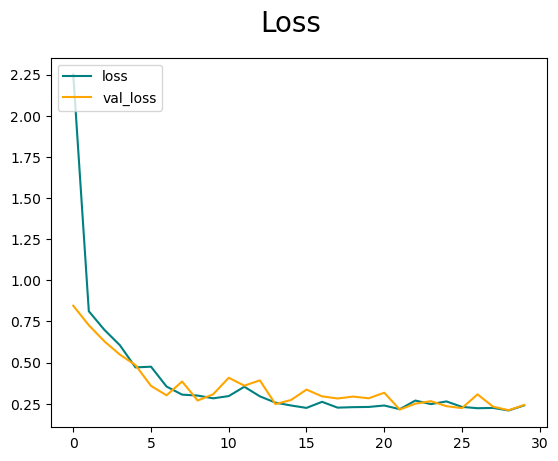

In [59]:
# FROM ISI'S - MODEL LOSS
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

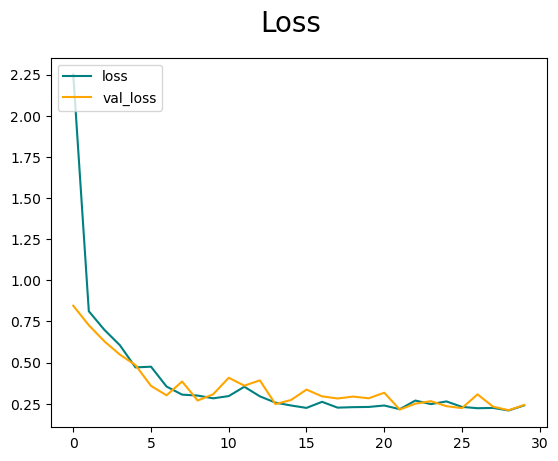

In [60]:
# ISI'S AGAIN - MODEL ACCURACY
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# OK IT'S ALL COPIED FROM ISI TILL THE END NOW, I HAVE NO SHAME. WILL ADAPT AND FIND OUT THE HOW-TOS TOMORROW. ISI IF YOU'RE READING THIS SENDING YOU <3 AND IN CASE YOU'RE WONDERING IF I'M INSANE FOR TALKING TO MYSELF WRITING ON THE NOTEBOOK THE ANSWER IS YES :P
checkpoint_path = os.path.join(data_path, "epochs", "save_at_29.keras")
model.load_weights(checkpoint_path)

2/2 [==============================] - 2s 1s/step


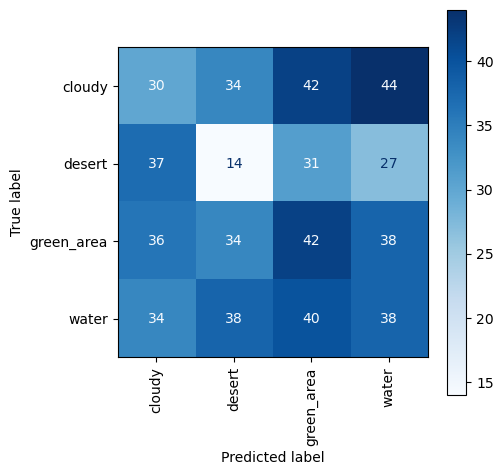

              precision    recall  f1-score     support
cloudy         0.218978  0.200000  0.209059  150.000000
desert         0.116667  0.128440  0.122271  109.000000
green_area     0.270968  0.280000  0.275410  150.000000
water          0.258503  0.253333  0.255892  150.000000
accuracy       0.221825  0.221825  0.221825    0.221825
macro avg      0.216279  0.215443  0.215658  559.000000
weighted avg   0.223585  0.221825  0.222508  559.000000


In [64]:
# CONFUSION MATRIX AND CLASSIFICATION REPORT
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
# true labels
true_labels = val_ds.classes

# predictions
predictions = model.predict(val_ds)
pred_labels = np.argmax(predictions, axis=-1)

# compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# class names
class_names = list(val_ds.class_indices.keys())

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Increase the size of the figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.show()

sns.set(font_scale=1.5)
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# report as a dataframe
print(df_report)